
In this notebook, we will do feature engineering, clustering, and classification on preprocessed dataset from MIMIC-IV-ED ad MIMIC-IV/hosp.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Initial imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# **Clustering**

In [3]:
# Scikit-learn library imports
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score

In [4]:
# Load merged df
final_df = pd.read_csv('/content/drive/MyDrive/BMI school/Course - BMI 5551/Analysis/MIMIC_data/ED/final_df.csv')
print(f"Final merged df shape: {final_df.shape}")
final_df.head(3)

Final merged df shape: (2966843, 27)


,subject_id,insurance,language,marital_status,anchor_age,chief_complaint_category,stay_id,temperature,heartrate,resprate,...,etccode,etcdescription,seq_num,icd_code,icd_title,gender,arrival_transport,disposition,ed_length_of_stay,race_consolidated
0,10000084,Medicare,English,MARRIED,72,Mental Health,36954971,98.7,80.0,16.0,...,3707.0,Antipsychotic -Atypical Dopamine-Serotonin Ant...,1,R4182,"Altered mental status, unspecified",M,AMBULANCE,HOME,21.583333,White
1,10000084,Medicare,English,MARRIED,72,Mental Health,36954971,98.7,80.0,16.0,...,290.0,Antihistamines - 2nd Generation,1,R4182,"Altered mental status, unspecified",M,AMBULANCE,HOME,21.583333,White
2,10000084,Medicare,English,MARRIED,72,Mental Health,36954971,98.7,80.0,16.0,...,2747.0,Antihyperlipidemic - HMG CoA Reductase Inhibit...,1,R4182,"Altered mental status, unspecified",M,AMBULANCE,HOME,21.583333,White


In [5]:
# count missing values
final_df.isna().sum()

,0
subject_id,0
insurance,0
language,0
marital_status,0
anchor_age,0
chief_complaint_category,0
stay_id,0
temperature,0
heartrate,0
resprate,0


In [6]:
# count of ED visits
final_df['stay_id'].nunique()

205685

In [7]:
# count of unique patients
final_df['subject_id'].nunique()

114042

In [8]:
# pain level is mixed text and numbers --> drop
# create a subset df and drop pain level
final_no_pain_df = final_df.copy()
final_no_pain_df.drop(['pain'], axis=1, inplace=True)
print(f"Shape of final_no_pain_df: {final_no_pain_df.shape}")
final_no_pain_df.head(3)

Shape of final_no_pain_df: (2966843, 26)


,subject_id,insurance,language,marital_status,anchor_age,chief_complaint_category,stay_id,temperature,heartrate,resprate,...,etccode,etcdescription,seq_num,icd_code,icd_title,gender,arrival_transport,disposition,ed_length_of_stay,race_consolidated
0,10000084,Medicare,English,MARRIED,72,Mental Health,36954971,98.7,80.0,16.0,...,3707.0,Antipsychotic -Atypical Dopamine-Serotonin Ant...,1,R4182,"Altered mental status, unspecified",M,AMBULANCE,HOME,21.583333,White
1,10000084,Medicare,English,MARRIED,72,Mental Health,36954971,98.7,80.0,16.0,...,290.0,Antihistamines - 2nd Generation,1,R4182,"Altered mental status, unspecified",M,AMBULANCE,HOME,21.583333,White
2,10000084,Medicare,English,MARRIED,72,Mental Health,36954971,98.7,80.0,16.0,...,2747.0,Antihyperlipidemic - HMG CoA Reductase Inhibit...,1,R4182,"Altered mental status, unspecified",M,AMBULANCE,HOME,21.583333,White


In [9]:
# df info
final_no_pain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966843 entries, 0 to 2966842
Data columns (total 26 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   subject_id                int64  
 1   insurance                 object 
 2   language                  object 
 3   marital_status            object 
 4   anchor_age                int64  
 5   chief_complaint_category  object 
 6   stay_id                   int64  
 7   temperature               float64
 8   heartrate                 float64
 9   resprate                  float64
 10  o2sat                     float64
 11  sbp                       float64
 12  dbp                       float64
 13  acuity                    float64
 14  name                      object 
 15  ndc                       float64
 16  etccode                   float64
 17  etcdescription            object 
 18  seq_num                   int64  
 19  icd_code                  object 
 20  icd_title               

# **Sampling the Data**

In [10]:
# Create a subset df with a random sample of 5000 unique stay ids
# Get a random sample of 5,000 unique stay IDs
unique_stay_ids = final_no_pain_df['stay_id'].unique()
sampled_stay_ids = np.random.choice(unique_stay_ids, size=min(5000, len(unique_stay_ids)), replace=False)

# Create a subset DataFrame with the sampled stay IDs
subset5000_df = final_no_pain_df[final_no_pain_df['stay_id'].isin(sampled_stay_ids)]

print(f"Shape of subset5000_df: {subset5000_df.shape}")

Shape of subset5000_df: (72024, 26)


In [11]:
# count of visits
print(f"Number of visits in subset of 5000: {subset5000_df['stay_id'].nunique()}")

Number of visits in subset of 5000: 5000


In [12]:
# count of patients
print(f"Number of patients in subset of 5000: {subset5000_df['subject_id'].nunique()}")

Number of patients in subset of 5000: 4782


## Preprocessing the Data for PCA

In [13]:
# Create a df that holds unnecessary columns
unnecessary_cols_df = subset5000_df.copy()
unnecessary_cols_df = unnecessary_cols_df[['subject_id', 'stay_id', 'name', 'icd_title', 'etcdescription']]
print(f"Shape of unnecessary_cols_df: {unnecessary_cols_df.shape}")
unnecessary_cols_df.head(3)

Shape of unnecessary_cols_df: (72024, 5)


,subject_id,stay_id,name,icd_title,etcdescription
84,10000891,37006387,unavailable,Cramp and spasm,Unavailable
85,10000891,37006387,unavailable,Pain in left lower leg,Unavailable
86,10000891,37006387,unavailable,Pain in right lower leg,Unavailable


In [14]:
# create a new df and drop unnecessary columns
prediction_df = subset5000_df.copy()
prediction_df.drop(['subject_id', 'stay_id', 'name', 'icd_title', 'etcdescription'], axis=1, inplace=True)
print(f"Shape of prediction_df: {prediction_df.shape}")
prediction_df.head(2)

Shape of prediction_df: (72024, 21)


,insurance,language,marital_status,anchor_age,chief_complaint_category,temperature,heartrate,resprate,o2sat,sbp,...,acuity,ndc,etccode,seq_num,icd_code,gender,arrival_transport,disposition,ed_length_of_stay,race_consolidated
84,Medicare,English,SINGLE,54,Pain/Discomfort,98.0,81.0,18.0,98.0,155.0,...,3.0,0.0,0.0,1,R252,F,WALK IN,HOME,5.533333,White
85,Medicare,English,SINGLE,54,Pain/Discomfort,98.0,81.0,18.0,98.0,155.0,...,3.0,0.0,0.0,2,M79662,F,WALK IN,HOME,5.533333,White


In [15]:
# create a new df that holds only the disposition (label)
disposition_df = prediction_df.copy()
disposition_df = disposition_df[['disposition']]
print(f"Shape of disposition_df: {disposition_df.shape}")
disposition_df.head(3)

Shape of disposition_df: (72024, 1)


,disposition
84,HOME
85,HOME
86,HOME


In [17]:
# drop the 'disposition' column since it's not going to be used in the clustering algorithm
mt_features_df = prediction_df.drop(['disposition'], axis=1)
print(f"Shape of mt_features_df: {mt_features_df.shape}")
mt_features_df.head(3)

Shape of mt_features_df: (72024, 20)


,insurance,language,marital_status,anchor_age,chief_complaint_category,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,ndc,etccode,seq_num,icd_code,gender,arrival_transport,ed_length_of_stay,race_consolidated
84,Medicare,English,SINGLE,54,Pain/Discomfort,98.0,81.0,18.0,98.0,155.0,89.0,3.0,0.0,0.0,1,R252,F,WALK IN,5.533333,White
85,Medicare,English,SINGLE,54,Pain/Discomfort,98.0,81.0,18.0,98.0,155.0,89.0,3.0,0.0,0.0,2,M79662,F,WALK IN,5.533333,White
86,Medicare,English,SINGLE,54,Pain/Discomfort,98.0,81.0,18.0,98.0,155.0,89.0,3.0,0.0,0.0,3,M79661,F,WALK IN,5.533333,White


In [18]:
# use get dummies() to create variables for text features
X = mt_features_df.copy()
X = pd.get_dummies(X, columns=['insurance', 'language', 'marital_status', 'chief_complaint_category', 'icd_code', 'gender', 'arrival_transport', 'race_consolidated'], drop_first=True)
print(f"Shape of X: {X.shape}")
X.head(3)

Shape of X: (72024, 1695)


,anchor_age,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,ndc,etccode,...,gender_M,arrival_transport_HELICOPTER,arrival_transport_OTHER,arrival_transport_UNKNOWN,arrival_transport_WALK IN,race_consolidated_Black,race_consolidated_Hispanic/Latino,race_consolidated_Native and Indigenous,race_consolidated_Other/Unknown,race_consolidated_White
84,54,98.0,81.0,18.0,98.0,155.0,89.0,3.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True
85,54,98.0,81.0,18.0,98.0,155.0,89.0,3.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True
86,54,98.0,81.0,18.0,98.0,155.0,89.0,3.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,True


In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72024 entries, 84 to 2966811
Columns: 1695 entries, anchor_age to race_consolidated_White
dtypes: bool(1683), float64(10), int64(2)
memory usage: 122.7 MB


In [20]:
# Standardize the data with StandardScaler()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[-0.31316022,  0.05996494, -0.16091255, ..., -0.06413035,
        -0.20884046,  0.7885873 ],
       [-0.31316022,  0.05996494, -0.16091255, ..., -0.06413035,
        -0.20884046,  0.7885873 ],
       [-0.31316022,  0.05996494, -0.16091255, ..., -0.06413035,
        -0.20884046,  0.7885873 ],
       ...,
       [-1.61490247, -0.28690798, -0.90557024, ..., -0.06413035,
        -0.20884046,  0.7885873 ],
       [-1.61490247, -0.28690798, -0.90557024, ..., -0.06413035,
        -0.20884046,  0.7885873 ],
       [-0.13564991,  0.05996494,  0.41190105, ..., -0.06413035,
        -0.20884046, -1.26809042]])

## Reducing data Dimension Using PCA

In [21]:
# Using PCA to reduce dimension to three principal components.
# Initialize the PCA model.
pca = PCA(n_components=3)

# Get 3 principal components for the cryptocurrency data.
X_pca = pca.fit_transform(X_scaled)
# Display results
X_pca

array([[-1.66006377, -0.47016781,  1.98422459],
       [-1.6503726 , -0.36642592,  1.44569774],
       [-1.33767282, -0.34262492,  1.9467472 ],
       ...,
       [-0.75815919,  0.07826894,  2.57756002],
       [-0.94648019,  0.05604808,  2.13574397],
       [-1.42015061,  0.53324265, -0.4124493 ]])

In [22]:
# Create a DataFrame with the three principal components.
df_X_pca = pd.DataFrame(data=X_pca, index=X.index, columns=["principal component 1", "principal component 2", "principal component 3"])
print(df_X_pca.shape)
df_X_pca.head(3)

(72024, 3)


,principal component 1,principal component 2,principal component 3
84,-1.660064,-0.470168,1.984225
85,-1.650373,-0.366426,1.445698
86,-1.337673,-0.342625,1.946747


##**Clustering ED Visits using K-Means**

### Finding the best value for K using the Elbow Curve

In [26]:
# create an elbow curve to find the best value for k.
# create an empty list to hold inertia values
inertia = []

# store a range of K values we want to test.
k=list(range(1, 11))

# Calculate the inertia for the rang of K values.
for i in k:
  kmeans = KMeans(n_clusters=i, random_state=0)
  kmeans.fit(df_X_pca)
  inertia.append(kmeans.inertia_)



# # loop through different values of k
# for k in range(1, 11):
#   # create a k-means model
#   kmeans = KMeans(n_clusters=k, random_state=0)
#   # fit the model to the data
#   kmeans.fit(df_X_pca)
#   # append the inertia value to the list
#   inertia_list.append(kmeans.inertia_)

<Axes: title={'center': 'Elbow Curve'}, xlabel='k'>

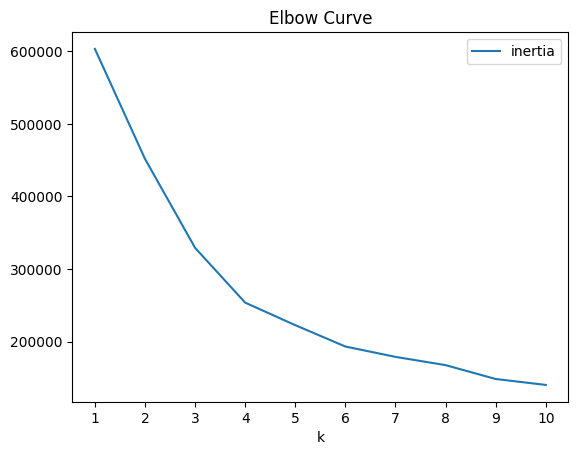

In [27]:
# Create the elbow curve dataframe and plot it
elbow_data = {'k': k, 'inertia': inertia}
elbow_df = pd.DataFrame(elbow_data)
elbow_df.plot.line(x='k', y='inertia', title='Elbow Curve', xticks=range(1, 11))

**Running K-Means with k=4**

In [28]:
# intialize the k-means model.
kmeans = KMeans(n_clusters=4, random_state=0)
# fit the model to the data
kmeans.fit(df_X_pca)
# predict clusters
predictions = kmeans.predict(df_X_pca)
predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [29]:
# Create a new DataFrame including predicted clusters and ED visit features.
# Concatentate the mt_features_df and df_X_pca DataFrames on the same columns.

combined_df = mt_features_df.join(df_X_pca, on=mt_features_df.index)
# print(combined_df.shape)
# combined_df.head()

#  Add a new column, "disposition" to the combined_df DataFrame that holds the disposition options.
# Use reset_index() to avoid potential index conflicts
clustered_df = combined_df.reset_index().join(disposition_df.reset_index(), on='index',  lsuffix='_caller', rsuffix='_other')
# print(clustered_df.shape)
# clustered_df.head()

# #  Add a new column, "Class" to the clustered_df DataFrame that holds the predictions.
clustered_df["Class"] = kmeans.labels_

# # Print the shape of the clustered_df
classes = clustered_df["Class"].unique()
print(clustered_df.shape)
print(f"Classes: {classes}")
clustered_df.head(5)

(72024, 29)
Classes: [1 3 0 2]


,index,index_caller,key_0,insurance,language,marital_status,anchor_age,chief_complaint_category,temperature,heartrate,...,gender,arrival_transport,ed_length_of_stay,race_consolidated,principal component 1,principal component 2,principal component 3,index_other,disposition,Class
0,84,84,84,Medicare,English,SINGLE,54,Pain/Discomfort,98.0,81.0,...,F,WALK IN,5.533333,White,-1.660064,-0.470168,1.984225,3806.0,ADMITTED,1
1,85,85,85,Medicare,English,SINGLE,54,Pain/Discomfort,98.0,81.0,...,F,WALK IN,5.533333,White,-1.650373,-0.366426,1.445698,3807.0,ADMITTED,1
2,86,86,86,Medicare,English,SINGLE,54,Pain/Discomfort,98.0,81.0,...,F,WALK IN,5.533333,White,-1.337673,-0.342625,1.946747,6205.0,ADMITTED,1
3,848,848,848,Medicare,English,MARRIED,68,Shortness of Breath,97.0,73.0,...,F,WALK IN,3.116667,Black,2.032547,0.327192,-2.448609,41487.0,HOME,3
4,849,849,849,Medicare,English,MARRIED,68,Shortness of Breath,97.0,73.0,...,F,WALK IN,3.116667,Black,2.161944,0.357274,-2.498372,41488.0,HOME,3


In [30]:
clustered_df['Class'].nunique()

4

In [31]:
clustered_df['Class'].value_counts()

,count
Class,
1,27437
0,19961
3,18806
2,5820


### **Visualize Disposition Results**

**3D-Scatter with Clusters**

In [45]:
# Create a DataFrame of components and clusters.
clusters_df = df_X_pca.copy()
clusters_df["Class"] = kmeans.labels_
print(clusters_df.shape)
clusters_df.head()

(72024, 4)


,principal component 1,principal component 2,principal component 3,Class
84,-1.660064,-0.470168,1.984225,1
85,-1.650373,-0.366426,1.445698,1
86,-1.337673,-0.342625,1.946747,1
848,2.032547,0.327192,-2.448609,3
849,2.161944,0.357274,-2.498372,3


In [32]:
clustered_df.columns

Index(['index', 'index_caller', 'key_0', 'insurance', 'language',
       'marital_status', 'anchor_age', 'chief_complaint_category',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity',
       'ndc', 'etccode', 'seq_num', 'icd_code', 'gender', 'arrival_transport',
       'ed_length_of_stay', 'race_consolidated', 'principal component 1',
       'principal component 2', 'principal component 3', 'index_other',
       'disposition', 'Class'],
      dtype='object')

In [33]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x="principal component 1",
    y="principal component 2",
    z="principal component 3",
    color="Class",
    symbol="Class",
    hover_name="disposition",
    hover_data={"chief_complaint_category": True},
    width=800,
    opacity=0.9,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

Output hidden; open in https://colab.research.google.com to view.

There are now four distinct groups that correspond to the four clusters that we expect the model to break the data into.

### **Model Evaluation**

In [34]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score

In [35]:
# create a function to calcualte evaluation metrics
def evaluate_clusters(true_labels, predicted_labels, feature_list):
    # Compute the Adjusted Rand Index (ARI)
    rand_index = adjusted_rand_score(true_labels, predicted_labels)

    # Compute the Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    return rand_index, nmi

    # Compute the Davies-Bouldin Index (DBI)
    dbi = davies_bouldin_score(feature_list, predicted_labels)
    return dbi

    # Compute the Calinski-Harabasz Index (CHI)
    chi = calinski_harabasz_score(feature_list, predicted_labels)
    return chi
    return rand_index, nmi, dbi, chi


In [37]:
# # evaluate the clustering results
# rand_index, nmi = evaluate_clusters(disposition_df, kmeans.labels_, df_X_pca)
# print('rand_index:', rand_index)
# print('NMI:', nmi)
# print('DBI (Davies-Bouldin Index):', dbi)
# print('CHI (Calinski-Harabasz Index):', chi)

In [38]:
# evaluate the clustering results
# Extract the 'disposition' column as a 1D array
true_labels = disposition_df['disposition'].values
rand_index, nmi = evaluate_clusters(true_labels, kmeans.labels_, df_X_pca)
print('rand_index:', rand_index)
print('NMI:', nmi)
# dbi and chi are not calculated in the evaluate_clusters function, so they can't be printed here.
# print('DBI (Davies-Bouldin Index):', dbi)
# print('CHI (Calinski-Harabasz Index):', chi)

rand_index: 0.06281591394274896
NMI: 0.04900012020480947


In [43]:
# Analyze the cluster with a function
def analyze_clusters(clustered_df):
    # TODO
    # Analyze the clusters and report your findings
    # For example, you can calculate the number of ED visits in each cluster,
    # the average age of ED visits in each cluster,
    # You can also visualize the clusters using scatter plots or dendrograms
    cluster_features = []
    for cluster in sorted(set(clustered_df['Class'])):
        visit_count = 0
        age_list = []
        gender_list = []
        cheifcomplain_list = []
        insurance_list = []

        for i in range(len(clustered_df)):
            if clustered_df['Class'].iloc[i] == cluster:
                visit_count += 1
                age_list.append(clustered_df['anchor_age'].iloc[i])
                gender_list.append(clustered_df['gender'].iloc[i] == 'M')
                cheifcomplain_list.append(clustered_df['chief_complaint_category'].iloc[i])
                insurance_list.append(clustered_df['insurance'].iloc[i])

        # Removed np.mod as it's unclear what the intended modulo operation was
        # If a modulo operation is needed, please specify the divisor
        cluster_features.append([visit_count, np.mean(age_list), np.mean(gender_list), cheifcomplain_list, insurance_list])


        print(f'Cluster: {cluster}       Visits: {visit_count}       Average Age: {np.mean(age_list):.2f}   Male(%): {np.mean(gender_list)*100:.2f}   Cheif Complain: {cheifcomplain_list}   Insurance: {insurance_list}')
#
#

analyze_clusters(clustered_df)

Cluster: 0       Visits: 19961       Average Age: 72.93   Male(%): 32.56   Cheif Complain: ['Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Pain/Discomfort', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 'Gastrointestinal', 

In [51]:
# get the count of chief complaint in class 0
clustered_df[clustered_df['Class'] == 0]['chief_complaint_category'].value_counts()
# calculate the proportions of chief complaints in class 0
clustered_df[clustered_df['Class'] == 0]['chief_complaint_category'].value_counts(normalize=True)

,proportion
chief_complaint_category,
Pain/Discomfort,0.351986
Trauma,0.233606
Other,0.231351
Dizziness/Syncope,0.050298
Shortness of Breath,0.046691
Mental Health,0.022293
Heart Disease,0.012474
Gastrointestinal,0.012074
Respiratory,0.011773


In [52]:
# Get the proportions of insurance in class 0
clustered_df[clustered_df['Class'] == 0]['insurance'].value_counts(normalize=True)

,proportion
insurance,
Medicare,0.956916
Medicaid,0.029858
Private,0.009819
Other,0.003357
No charge,0.000050


In [54]:
# get the count of chief complaint in class 1
clustered_df[clustered_df['Class'] == 1]['chief_complaint_category'].value_counts()
# calculate the proportions of chief complaints in class 1
clustered_df[clustered_df['Class'] == 1]['chief_complaint_category'].value_counts(normalize=True)

,proportion
chief_complaint_category,
Pain/Discomfort,0.663775
Other,0.209607
Dizziness/Syncope,0.023071
Trauma,0.019390
Mental Health,0.017823
Shortness of Breath,0.014652
Allergy,0.010679
Respiratory,0.009221
Infectious Disease,0.006087


In [ ]:
from sklearn.metrics import pairwise_distances
distance_matrix = pairwise_distances(df_X_pca) # Calculate distance matrix using euclidean distance as default.

In [ ]:
# # identify k value
# import matplotlib.pyplot as plt
# metric_list = []
# ks = [2,3,4,5]
# for k in ks:
#     # Cluster the patients into k clusters
#     distance_matrix = pairwise_distances(df_X_pca)
#     cluster_labels = kmeans_clustering(distance_matrix, n_clusters=k)
#     # Evaluate the clustering results
#     metric = evaluate_clusters(cluster_labels, cluster_results.labels_, feature_list)
#     metric_list.append(metric)

# metrics = np.array(metric_list)
# for i, metric_name in enumerate(['RI', 'NMI', 'DBI', 'CHI']):
#     plt.plot(ks, metrics[:, i], label=metric_name)
#     plt.title(metric_name)
#     plt.show()